In [87]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
from hmmlearn import hmm

In [84]:
def create_graph():
    # Create a 10x10 grid graph
    G = nx.grid_2d_graph(10, 10)

    # Assign (x, y) as a property of each node
    for node in G.nodes():
        G.nodes[node]['pos'] = node  # Storing position as a property

    # Draw the graph with labels
    plt.figure(figsize=(8, 8))
    pos = {node: (node[0], node[1]) for node in G.nodes()} 
    nx.draw(G, pos, with_labels=True, node_size=300, node_color='lightblue', edge_color='gray')
    plt.show()
    
    return G

In [99]:
def generate_random_walks(G, epsilon, num_points):
    
    # Generate random starting point
    random_node = random.choice(list(G.nodes()))
    # print(f"Start node: {random_node}")
    
    epsilon_x = np.random.normal(0, np.sqrt(epsilon))
    epsilon_y = np.random.normal(0, np.sqrt(epsilon))
    first_noisy_point = (random_node[0] + epsilon_x, random_node[1] + epsilon_y)

    actual_points = [random_node]
    trajectory = [first_noisy_point]
    
    # Generate a random walk and associated noisy points
    for _ in range(num_points - 1):
        node = actual_points[-1]
        
        # Get a random neighbor
        neighbors = list(G.neighbors(node))  
        rand_neighbor = random.choice(neighbors)
        
        epsilon_x = np.random.normal(0, np.sqrt(epsilon))
        epsilon_y = np.random.normal(0, np.sqrt(epsilon))
        noisy_point = (rand_neighbor[0] + epsilon_x, rand_neighbor[1] + epsilon_y)
        
        actual_points.append(rand_neighbor)
        trajectory.append(noisy_point)

    return actual_points, trajectory
        

In [ ]:
def build_hmm(G, epsilon):

    states = list(G.nodes()) 
    n_states = len(states)

    # Transition matrix (uniform probability among neighbors)
    transition_matrix = np.zeros((n_states, n_states))
    for i, node in enumerate(states):
        neighbors = list(G.neighbors(node))
        if neighbors:
            for neighbor in neighbors:
                j = states.index(neighbor)
                transition_matrix[i, j] = 1 / len(neighbors)

    # Emission model (Gaussian noise around true position)
    means = np.array(states) 
    covars = np.full((n_states, 2, 2), np.eye(2) * epsilon) 

    # Define HMM
    model = hmm.GaussianHMM(n_components=n_states, covariance_type="full", n_iter=100)
    model.startprob_ = np.full(n_states, 1 / n_states)  # Uniform start probability
    model.transmat_ = transition_matrix 
    model.means_ = means  
    model.covars_ = covars 

    return model, states

In [ ]:
def train_and_predict(G, epsilon, noisy_observations):
   
    model, states = build_hmm(G, epsilon)
    
    obs = np.array(noisy_observations)

    # Fit and predict most likely hidden states
    predicted_indices = model.predict(obs)
    predicted_states = [states[i] for i in predicted_indices]

    return predicted_states

In [ ]:
def evaluate_accuracy(true_states, predicted_states):
  
    correct = sum(t == p for t, p in zip(true_states, predicted_states))
    return correct / len(true_states)

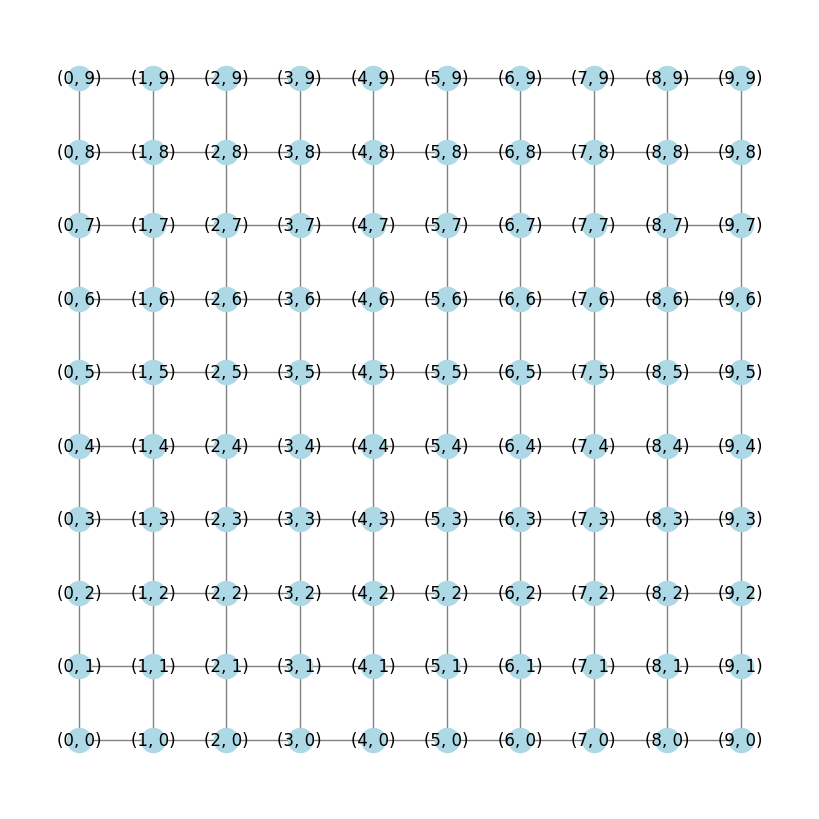

Noise level: 0.1


In [ ]:
# Vary epsilon and measure accuracy
epsilons = np.arange(0.1, 3.1, 0.1)
accuracies = []

G = create_graph()  # Generate graph once

for epsilon in epsilons:
    print(f"Noise level: {epsilon}")
    # Run each epsilon 10 times to get the average result
    n = 100
    total = 0
    for _ in range(n):
        true_states, noisy_obs = generate_random_walks(G, epsilon, num_points=30)
        # print(f"True states: {true_states}")
        # print(f"Noisy states: {noisy_obs}")
        predicted_states = train_and_predict(G, epsilon, noisy_obs)
        # print(f"Predicted States: {predicted_states}")
        accuracy = evaluate_accuracy(true_states, predicted_states)
        total += accuracy
        
    accuracies.append(total / n)

# Plot accuracy vs. noise level
plt.figure(figsize=(8, 5))
plt.plot(epsilons, accuracies, marker='o', linestyle='-', color='b')
plt.xlabel("Noise Level (ε)")
plt.ylabel("Accuracy of Predicted Trajectory")
plt.title("HMM Prediction Accuracy vs. Noise Level")
plt.grid()